In [2]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import numpy as np
import random
import math
import os

# Parameters
epsilon = 1  # The probability of choosing a random action (in training). This decays as iterations increase. (0 to 1)
epsilonMinimumValue = 0.001 # The minimum value we want epsilon to reach in training. (0 to 1)
nbActions = 3 # The number of actions. Since we only have left/stay/right that means 3 actions.
epoch = 1001 # The number of games we want the system to run for.
hiddenSize = 100 # Number of neurons in the hidden layers.
maxMemory = 500 # How large should the memory be (where it stores its past experiences).
batchSize = 50 # The mini-batch size for training. Samples are randomly taken from memory till mini-batch size.
gridSize = 10 # The size of the grid that the agent is going to play the game on.
nbStates = gridSize * gridSize # We eventually flatten to a 1d tensor to feed the network.
discount = 0.9 # The discount is used to force the network to choose states that lead to the reward quicker (0 to 1)  
learningRate = 0.2 # Learning Rate for Stochastic Gradient Descent (our optimizer).

# Create the base model.
X = tf.placeholder(tf.float32, [None, nbStates])
W1 = tf.Variable(tf.truncated_normal([nbStates, hiddenSize], stddev=1.0 / math.sqrt(float(nbStates))))
b1 = tf.Variable(tf.truncated_normal([hiddenSize], stddev=0.01))  
input_layer = tf.nn.relu(tf.matmul(X, W1) + b1)
W2 = tf.Variable(tf.truncated_normal([hiddenSize, hiddenSize],stddev=1.0 / math.sqrt(float(hiddenSize))))
b2 = tf.Variable(tf.truncated_normal([hiddenSize], stddev=0.01))
hidden_layer = tf.nn.relu(tf.matmul(input_layer, W2) + b2)
W3 = tf.Variable(tf.truncated_normal([hiddenSize, nbActions],stddev=1.0 / math.sqrt(float(hiddenSize))))
b3 = tf.Variable(tf.truncated_normal([nbActions], stddev=0.01))
output_layer = tf.matmul(hidden_layer, W3) + b3

# True labels
Y = tf.placeholder(tf.float32, [None, nbActions])

# Mean squared error cost function
cost = tf.reduce_sum(tf.square(Y-output_layer)) / (2*batchSize)

# Stochastic Gradient Decent Optimizer
optimizer = tf.train.GradientDescentOptimizer(learningRate).minimize(cost)


# Helper function: Chooses a random value between the two boundaries.
def randf(s, e):
    return (float(random.randrange(0, (e - s) * 9999)) / 10000) + s;


# The environment: Handles interactions and contains the state of the environment
class CatchEnvironment():
    def __init__(self, gridSize):
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.state = np.empty(3, dtype = np.uint8) 

#   Returns the state of the environment.
    def observe(self):
        canvas = self.drawState()
        canvas = np.reshape(canvas, (-1,self.nbStates))
        return canvas

    def drawState(self):
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas[self.state[0]-1, self.state[1]-1] = 1  # Draw the fruit.
        # Draw the basket. The basket takes the adjacent two places to the position of basket.
        canvas[self.gridSize-1, self.state[2] -1 - 1] = 1
        canvas[self.gridSize-1, self.state[2] -1] = 1
        canvas[self.gridSize-1, self.state[2] -1 + 1] = 1    
        return canvas        

#   Resets the environment. Randomly initialise the fruit position (always at the top to begin with) and bucket.
    def reset(self): 
        initialFruitColumn = random.randrange(1, self.gridSize + 1)
        initialBucketPosition = random.randrange(2, self.gridSize + 1 - 1)
        self.state = np.array([1, initialFruitColumn, initialBucketPosition]) 
        return self.getState()

    def getState(self):
        stateInfo = self.state
        fruit_row = stateInfo[0]
        fruit_col = stateInfo[1]
        basket = stateInfo[2]
        return fruit_row, fruit_col, basket

#   Returns the award that the agent has gained for being in the current environment state.
    def getReward(self):
        fruitRow, fruitColumn, basket = self.getState()
        if (fruitRow == self.gridSize - 1):  # If the fruit has reached the bottom.
            if (abs(fruitColumn - basket) <= 1): # Check if the basket caught the fruit.
                return 1
            else:
                return -1
        else:
            return 0

    def isGameOver(self):
        if (self.state[0] == self.gridSize - 1): 
            return True 
        else: 
            return False 

    def updateState(self, action):
        if (action == 1):
            action = -1
        elif (action == 2):
            action = 0
        else:
            action = 1
        fruitRow, fruitColumn, basket = self.getState()
        newBasket = min(max(2, basket + action), self.gridSize - 1) # The min/max prevents the basket from moving out of the grid.
        fruitRow = fruitRow + 1  # The fruit is falling by 1 every action.
        self.state = np.array([fruitRow, fruitColumn, newBasket])

#   Action can be 1 (move left) or 2 (move right)
    def act(self, action):
        self.updateState(action)
        reward = self.getReward()
        gameOver = self.isGameOver()
        return self.observe(), reward, gameOver, self.getState()   # For purpose of the visual, I also return the state.


# The memory: Handles the internal memory that we add experiences that occur based on agent's actions,
# and creates batches of experiences based on the mini-batch size for training.
class ReplayMemory:
    def __init__(self, gridSize, maxMemory, discount):
        self.maxMemory = maxMemory
        self.gridSize = gridSize
        self.nbStates = self.gridSize * self.gridSize
        self.discount = discount
        canvas = np.zeros((self.gridSize, self.gridSize))
        canvas = np.reshape(canvas, (-1,self.nbStates))
        self.inputState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.actions = np.zeros(self.maxMemory, dtype = np.uint8)
        self.nextState = np.empty((self.maxMemory, 100), dtype = np.float32)
        self.gameOver = np.empty(self.maxMemory, dtype = np.bool)
        self.rewards = np.empty(self.maxMemory, dtype = np.int8) 
        self.count = 0
        self.current = 0

#   Appends the experience to the memory.
    def remember(self, currentState, action, reward, nextState, gameOver):
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.inputState[self.current, ...] = currentState
        self.nextState[self.current, ...] = nextState
        self.gameOver[self.current] = gameOver
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.maxMemory

    def getBatch(self, model, batchSize, nbActions, nbStates, sess, X):
    
        # We check to see if we have enough memory inputs to make an entire batch, if not we create the biggest
        # batch we can (at the beginning of training we will not have enough experience to fill a batch).
        memoryLength = self.count
        chosenBatchSize = min(batchSize, memoryLength)

        inputs = np.zeros((chosenBatchSize, nbStates))
        targets = np.zeros((chosenBatchSize, nbActions))

        # Fill the inputs and targets up.
        for i in range(chosenBatchSize):
            if memoryLength == 1:
                memoryLength = 2
            # Choose a random memory experience to add to the batch.
            randomIndex = random.randrange(1, memoryLength)
            current_inputState = np.reshape(self.inputState[randomIndex], (1, 100))

            target = sess.run(model, feed_dict={X: current_inputState})

            current_nextState =  np.reshape(self.nextState[randomIndex], (1, 100))
            current_outputs = sess.run(model, feed_dict={X: current_nextState})      

            # Gives us Q_sa, the max q for the next state.
            nextStateMaxQ = np.amax(current_outputs)
            if (self.gameOver[randomIndex] == True):
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex]
            else:
                # reward + discount(gamma) * max_a' Q(s',a')
                # We are setting the Q-value for the action to  r + gamma*max a' Q(s', a'). The rest stay the same
                # to give an error of 0 for those outputs.
                target[0, [self.actions[randomIndex]-1]] = self.rewards[randomIndex] + self.discount * nextStateMaxQ

            # Update the inputs and targets.
            inputs[i] = current_inputState
            targets[i] = target

        return inputs, targets


Instructions for updating:
non-resource variables are not supported in the long term


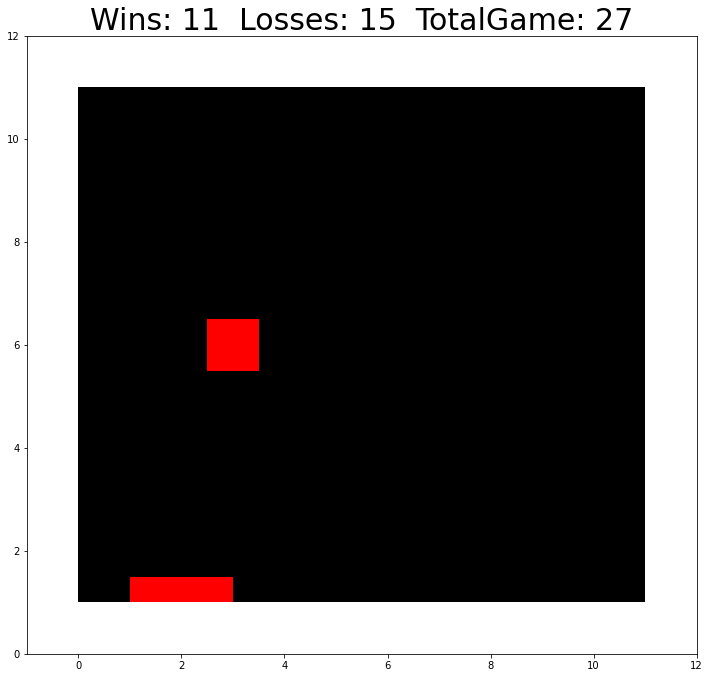

KeyboardInterrupt: 

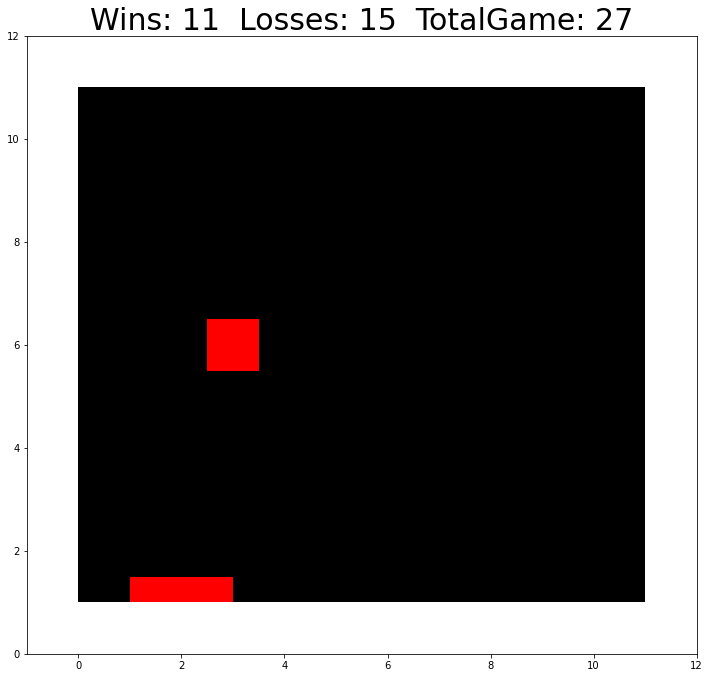

In [11]:
# To run this code you must use iPython. Also you can use the .ipynb file in ipython notebook mode.

%matplotlib
%matplotlib inline

# from TrainCatchGame import CatchEnvironment, X, W1, b1, input_layer, W2, b2, hidden_layer, W3, b3, output_layer, Y, cost, optimizer
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab as pl
import time
# import tensorflow as tf
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import math
import os


gridSize = 10 # The size of the grid that the agent is going to play the game on.
maxGames = 100
env = CatchEnvironment(gridSize)
winCount = 0
loseCount = 0
numberOfGames = 0

ground = 1
plot = pl.figure(figsize=(12,12))
axis = plot.add_subplot(111, aspect='equal')
axis.set_xlim([-1, 12])
axis.set_ylim([0, 12])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

def drawState(fruitRow, fruitColumn, basket):
  global gridSize
  # column is the x axis
  fruitX = fruitColumn 
  # Invert matrix style points to coordinates
  fruitY = (gridSize - fruitRow + 1)
  statusTitle = "Wins: " + str(winCount) + "  Losses: " + str(loseCount) + "  TotalGame: " + str(numberOfGames)
  axis.set_title(statusTitle, fontsize=30)
  for p in [
    patches.Rectangle(
        ((ground - 1), (ground)), 11, 10,
        facecolor="#000000"      # Black
    ),
    patches.Rectangle(
        (basket - 1, ground), 2, 0.5,
        facecolor="#FF0000"     # No background
    ),
    patches.Rectangle(
        (fruitX - 0.5, fruitY - 0.5), 1, 1,
        facecolor="#FF0000"       # red 
    ),   
    ]:
      axis.add_patch(p)
  display.clear_output(wait=True)
  display.display(pl.gcf())


with tf.Session() as sess:    
  # Restore variables from disk.
  saver.restore(sess, os.getcwd()+"/model.ckpt")
  print('saved model is loaded!')

  while (numberOfGames < maxGames):
    numberOfGames = numberOfGames + 1
     
    # The initial state of the environment.
    isGameOver = False
    fruitRow, fruitColumn, basket = env.reset()
    currentState = env.observe()
    drawState(fruitRow, fruitColumn, basket)

    while (isGameOver != True):
      # Forward the current state through the network.
      q = sess.run(output_layer, feed_dict={X: currentState})
      # Find the max index (the chosen action).
      index = q.argmax()
      action = index + 1
      nextState, reward, gameOver, stateInfo = env.act(action)    
      fruitRow = stateInfo[0]
      fruitColumn = stateInfo[1]
      basket = stateInfo[2]
     
      # Count game results
      if (reward == 1):
        winCount = winCount + 1
      elif (reward == -1):
        loseCount = loseCount + 1

      currentState = nextState
      isGameOver = gameOver
      drawState(fruitRow, fruitColumn, basket)
      time.sleep(0.4)

display.clear_output(wait=True)
